# Results Analysis

1. Best combinaison
2. Removing experiments where the number of parseable prediction was to low (NaN sum() must be < 250/1000)
3. Removing outliers
4. Must impactfull criteria






In [74]:
import pandas as pd
import pickle as pk
from pipeline_config import list_of_models, list_of_prompts, quantizations
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

prediction = pd.read_csv(f"outputs/cities_prediction.csv")
common_columns = ["Geoname ID", "Name", "ASCII Name", "Alternate Names", "Feature Class", "Feature Code", "Country Code", "Country name EN", "Country Code 2", "Admin1 Code", "Admin2 Code", "Admin3 Code", "Admin4 Code", "Population", "Elevation", "DIgital Elevation Model", "Timezone", "Modification date", "LABEL EN", "Coordinates", "city"]


## 1. Best / Worst combinaisons

Distance min/max/average by combinaison

In [75]:
import numpy as np

# Compute mean, standard deviation, and count of non-NaN values for columns containing "distance"
distance_stats = {
    k: (prediction[k].mean(), prediction[k].std(), prediction[k].count()) 
    for k in prediction.keys() if "distance" in k
}

# Sort columns by their mean value
sorted_columns = sorted(distance_stats.items(), key=lambda item: item[1][0])

# Select the 5 best (lowest mean) and 5 worst (highest mean) columns
best_5 = sorted_columns[:5]   # Top 5 best (lowest mean)
worst_5 = sorted_columns[-5:] # Top 5 worst (highest mean)

# Display results
print("🏆 **Top 5 Best Columns** (Lowest Mean):")
for col, (mean, std, count) in best_5:
    print(f"{col} | Mean: {mean:.4f} | STD: {std:.4f} | Non-NaN values: {count}")

print("\n💀 **Top 5 Worst Columns** (Highest Mean):")
for col, (mean, std, count) in reversed(worst_5):  # Reverse to show the worst first
    print(f"{col} | Mean: {mean:.4f} | STD: {std:.4f} | Non-NaN values: {count}")


🏆 **Top 5 Best Columns** (Lowest Mean):
mistralai/Mistral-Small-24B-Base-2501_float16_gps_fr_distance | Mean: 87.0070 | STD: 672.1141 | Non-NaN values: 904
meta-llama/Llama-3.2-3B_int4_gps_fr_distance | Mean: 88.6713 | STD: 187.2747 | Non-NaN values: 38
mistralai/Mistral-Small-24B-Instruct-2501_int4_gps_fr_distance | Mean: 103.0866 | STD: 557.3441 | Non-NaN values: 699
meta-llama/Llama-2-13b-hf_int8_gps_fr_distance | Mean: 108.8562 | STD: 168.5298 | Non-NaN values: 35
mistralai/Mistral-Small-24B-Base-2501_int8_gps_fr_distance | Mean: 113.4336 | STD: 830.8944 | Non-NaN values: 792

💀 **Top 5 Worst Columns** (Highest Mean):
Qwen/Qwen2.5-72B-Instruct_int4_gps_en_distance | Mean: nan | STD: nan | Non-NaN values: 0
Qwen/Qwen2.5-72B-Instruct_int4_gps_fr_distance | Mean: nan | STD: nan | Non-NaN values: 0
meta-llama/Llama-3.1-8B-Instruct_float16_gps_fr_distance | Mean: 6290.6920 | STD: 5321.7150 | Non-NaN values: 607
meta-llama/Llama-2-13b-chat-hf_float16_gps_fr_distance | Mean: 6127.1839 | S

In [76]:
# Mistral-Nemo-Base-2407 doesn't have the number of parameters in its name. We have to add it
distance_columns = [col for col in prediction.columns if "distance" in col]

for col in distance_columns:
    try:
        re.search(r'(\d+\.?\d*B)', col, re.VERBOSE | re.IGNORECASE).group(1) 
    except:
        print(col)
        col_new_name = col + "_12B"
        prediction[col_new_name] = prediction[col]
        prediction = prediction.drop(columns=[col])


In [77]:
def extract_fine_tuning(col):
    allowed_values = {"instruct", "chat"}
    if "instruct" in col.lower():
        return "instruct"
    elif "chat" in col.lower():
        return "chat"
    else:
        return "base"

distance_columns = [col for col in prediction.columns if "distance" in col]
distance_means = [prediction[col].mean() for col in distance_columns]
nan_counts = [prediction[col].isna().sum() for col in distance_columns]
df = pd.DataFrame({
    "distance_mean": distance_means,
    "nan_counts": nan_counts,
    "model_family": [col.lower().split("/")[-1].split("b")[0].rsplit("-",1)[0] for col in distance_columns],
    "model_size": [re.search(r'(\d+\.?\d*B)', col, re.VERBOSE | re.IGNORECASE).group(1) for col in distance_columns],
    "quantization": [col.split("_")[1] for col in distance_columns],
    "lang_prompt": [col.split("_")[3] for col in distance_columns],
    "prompt_type": [col.split("_")[2] for col in distance_columns],
    "version": [col.lower().split("/")[-1].split("b",1)[-1].split("_")[0].split("-")[-1] for col in distance_columns],
    "fine_tuning": [extract_fine_tuning(col) for col in distance_columns],
})

# Only for mistral: get version of the model family:
df['model_family'] = df.apply(
    lambda row: f"{row['model_family']}_{row['version']}" if row['model_family'] == 'mistral' and row['version'] != 'instruct' else row['model_family'],
    axis=1
)
df = df.drop('version', axis=1)

df.sort_values("distance_mean")

,distance_mean,nan_counts,model_family,model_size,quantization,lang_prompt,prompt_type,fine_tuning
24,87.007043,96,mistral-small,24B,float16,fr,gps,base
52,88.671328,962,llama-3.2,3B,int4,fr,gps,base
34,103.086592,301,mistral-small,24B,int4,fr,gps,instruct
86,108.856220,965,llama-2,13b,int8,fr,gps,base
26,113.433558,208,mistral-small,24B,int8,fr,gps,base
...,...,...,...,...,...,...,...,...
68,6050.358930,243,llama-3.1,8B,int8,fr,gps,instruct
90,6127.183905,29,llama-2,13b,float16,fr,gps,chat
66,6290.692041,393,llama-3.1,8B,float16,fr,gps,instruct
144,NaN,1000,qwen2.5,72B,int4,fr,gps,instruct


## 2. Removing experiments where the number of parseable prediction was to low 

In [78]:
# Convert model size to numeric and treat it as categorical
df["model_size_num"] = df["model_size"].str.lower().str.replace("b", "", regex=True).astype(float)
df["model_size_str"] = df["model_size"].str.upper()  # Keep labels as "3B", "7B", etc.

# Convert quantization levels to numeric values
quantization_map = {"float16": 16, "int8": 8, "int4": 4}
df["quantization_num"] = df["quantization"].map(quantization_map)

# Define fixed spacing for x-axis (e.g., every 5 units apart)
fixed_positions = np.arange(1, len(df["model_size_num"].unique()) * 5, step=5)  
size_mapping = {size: pos for size, pos in zip(sorted(df["model_size_num"].unique()), fixed_positions)}
df["model_size_fixed"] = df["model_size_num"].map(size_mapping)  # Assign fixed positions

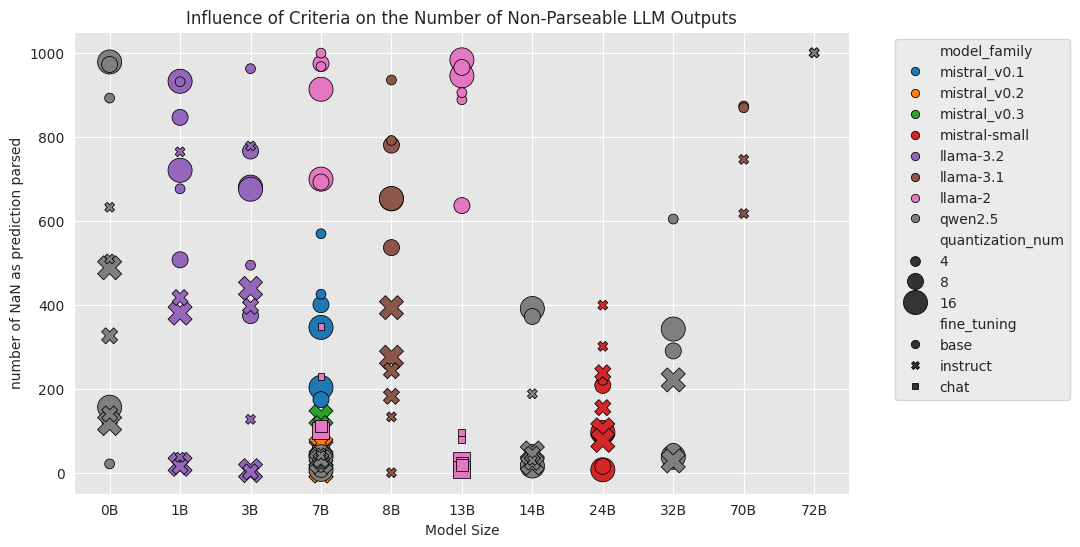

In [79]:

# Set plot style
plt.figure(figsize=(10, 6))

# Create scatter plot with adjusted x-axis
ax = sns.scatterplot(
    data=df,
    x="model_size_fixed",  # Use fixed x positions
    y="nan_counts",
    hue="model_family",
    style="fine_tuning",
    size="quantization_num",
    sizes=(50, 300),
    edgecolor="black"
)

# Set evenly spaced x-ticks with correct labels
ax.set_xticks(fixed_positions)
ax.set_xticklabels([f"{int(size)}B" for size in sorted(df["model_size_num"].unique())])  # Labels as "3B", "7B", etc.

# Add labels and title
plt.xlabel("Model Size")
plt.ylabel("number of NaN as prediction parsed")
plt.title("Influence of Criteria on the Number of Non-Parseable LLM Outputs")

# Move the legend to avoid overlap
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Show the plot
plt.show()


## Without experiments where NaN sum() too high

**Remove columns when there is not enough distance computed (~750)**: we remove column when there is at least more than (1000-250 = 750) NaN

Removing expe when NaN number is > 250: 63 deleted


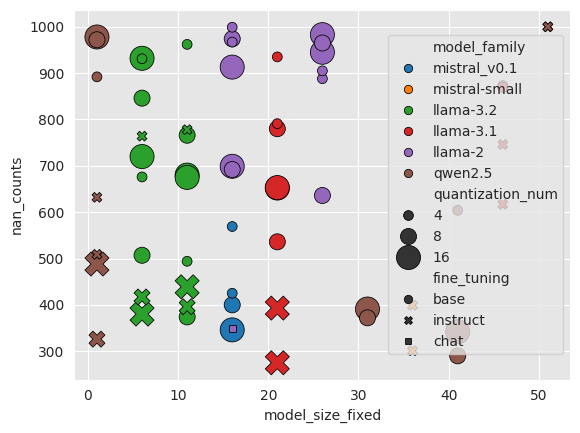

In [80]:
# Convert model size to numeric and treat it as categorical
df["model_size_num"] = df["model_size"].str.lower().str.replace("b", "", regex=True).astype(float)
df["model_size_str"] = df["model_size"].str.upper()  # Keep labels as "3B", "7B", etc.


# prediction_without_nan = prediction.dropna(axis=1, thresh=len(prediction) - 250)
print(f"Removing expe when NaN number is > 250: {len(df)- len(df[df['nan_counts'] < 250]) } deleted")
df_nan = df[df["nan_counts"] > 251].copy()
df = df[df["nan_counts"] < 250]




ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (11).

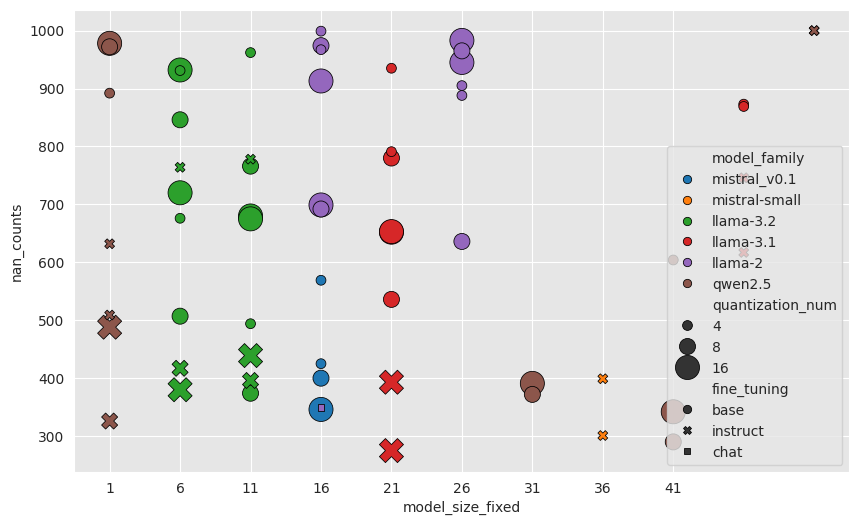

In [93]:
plt.figure(figsize=(10, 6))

ax = sns.scatterplot(
    data=df_nan,
    x="model_size_fixed",  # Use fixed x positions
    y="nan_counts",
    hue="model_family",
    style="fine_tuning",
    size="quantization_num",
    sizes=(50, 300),
    edgecolor="black"
)
fixed_positions = np.arange(1, len(df_nan["model_size_num"].unique()) * 5, step=5) 
ax.set_xticks(fixed_positions)
ax.set_xticklabels([f"{int(size)}B" for size in sorted(df_nan["model_size_num"].unique())])  # Labels as "3B", "7B", etc.

# Add labels and title
plt.xlabel("Model Size")
plt.ylabel("Number of NaN as GPS coordinates")
plt.title("Experiments remove for others analysis because too much NaN for GPS coordinates")

# Move the legend to avoid overlap
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Show the plot
plt.show()


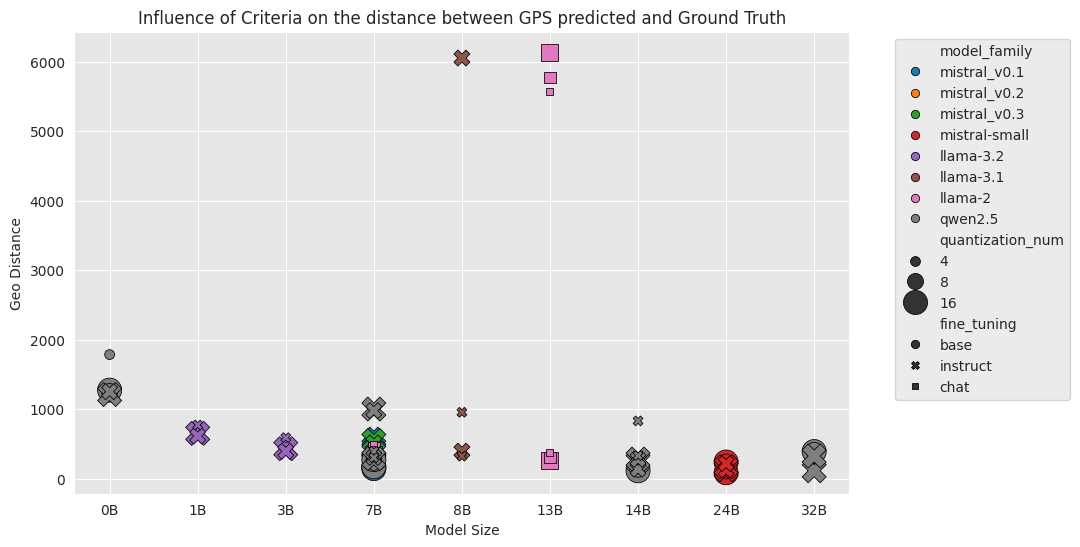

In [82]:


# Convert quantization levels to numeric values
quantization_map = {"float16": 16, "int8": 8, "int4": 4}
df["quantization_num"] = df["quantization"].map(quantization_map)

# Define fixed spacing for x-axis (e.g., every 5 units apart)
fixed_positions = np.arange(1, len(df["model_size_num"].unique()) * 5, step=5)  
size_mapping = {size: pos for size, pos in zip(sorted(df["model_size_num"].unique()), fixed_positions)}
df["model_size_fixed"] = df["model_size_num"].map(size_mapping)  # Assign fixed positions

# Set plot style
plt.figure(figsize=(10, 6))

# Create scatter plot with adjusted x-axis
ax = sns.scatterplot(
    data=df,
    x="model_size_fixed",  # Use fixed x positions
    y="distance_mean",
    hue="model_family",
    style="fine_tuning",
    size="quantization_num",
    sizes=(50, 300),
    edgecolor="black"
)

# Set evenly spaced x-ticks with correct labels
ax.set_xticks(fixed_positions)
ax.set_xticklabels([f"{int(size)}B" for size in sorted(df["model_size_num"].unique())])  # Labels as "3B", "7B", etc.

# Add labels and title
plt.xlabel("Model Size")
plt.ylabel("Geo Distance")
plt.title("Influence of Criteria on the distance between GPS predicted and Ground Truth")

# Move the legend to avoid overlap
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Show the plot
plt.show()


## 3. Without outliers

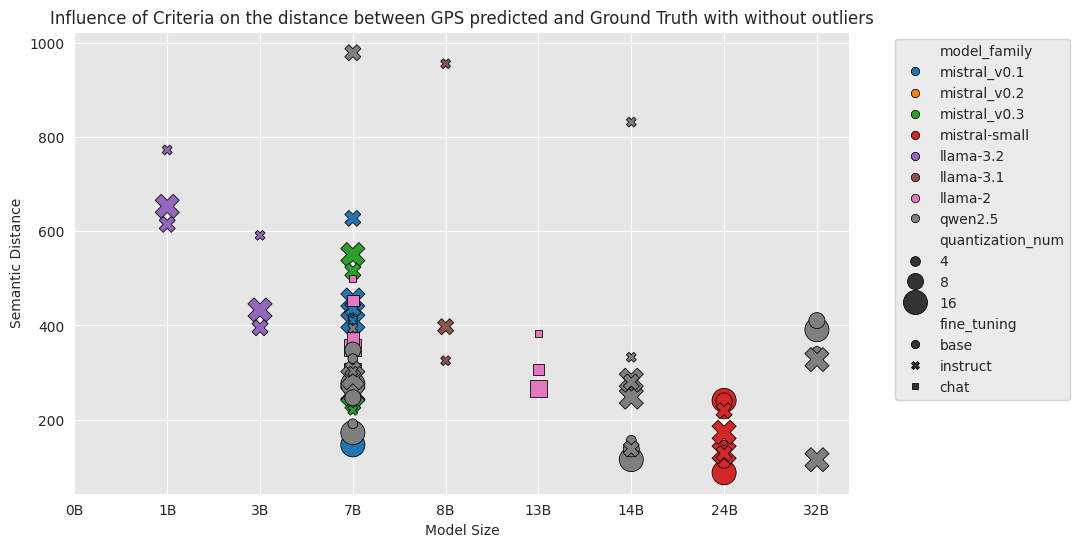

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
plt.figure(figsize=(10, 6))

# Create scatter plot with adjusted x-axis
ax = sns.scatterplot(
    data=df[df["distance_mean"] < 1000],
    x="model_size_fixed",  # Use fixed x positions
    y="distance_mean",
    hue="model_family",
    style="fine_tuning",
    size="quantization_num",
    sizes=(50, 300),
    edgecolor="black"
)

# Set evenly spaced x-ticks with correct labels
ax.set_xticks(fixed_positions)
ax.set_xticklabels([f"{int(size)}B" for size in sorted(df["model_size_num"].unique())])  # Labels as "3B", "7B", etc.

# Add labels and title
plt.xlabel("Model Size")
plt.ylabel("Semantic Distance")
plt.title("Influence of Criteria on the distance between GPS predicted and Ground Truth with without outliers")

# Move the legend to avoid overlap
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


# Show the plot
plt.show()


## 4. Most impactfull criteria

In [84]:
df[['distance_mean', 'model_family', 'model_size', 'quantization', 'lang_prompt', 'fine_tuning']]

,distance_mean,model_family,model_size,quantization,lang_prompt,fine_tuning
0,146.241734,mistral_v0.1,7B,float16,fr,base
2,166.194266,mistral_v0.1,7B,int8,fr,base
6,453.944515,mistral_v0.1,7B,float16,fr,instruct
7,408.690671,mistral_v0.1,7B,float16,en,instruct
8,627.397858,mistral_v0.1,7B,int8,fr,instruct
...,...,...,...,...,...,...
137,390.923001,qwen2.5,32B,float16,en,base
139,410.140743,qwen2.5,32B,int8,en,base
141,344.643812,qwen2.5,32B,int4,en,base
142,114.774618,qwen2.5,32B,float16,fr,instruct


/tmp/ipykernel_4008488/1417370653.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y="distance_mean", palette="Blues_r", ax=ax)
/tmp/ipykernel_4008488/1417370653.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y="distance_mean", palette="Blues_r", ax=ax)
/tmp/ipykernel_4008488/1417370653.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y="distance_mean", palette="Blues_r", ax=ax)
/tmp/ipykernel_4008488/1417370653.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is depr

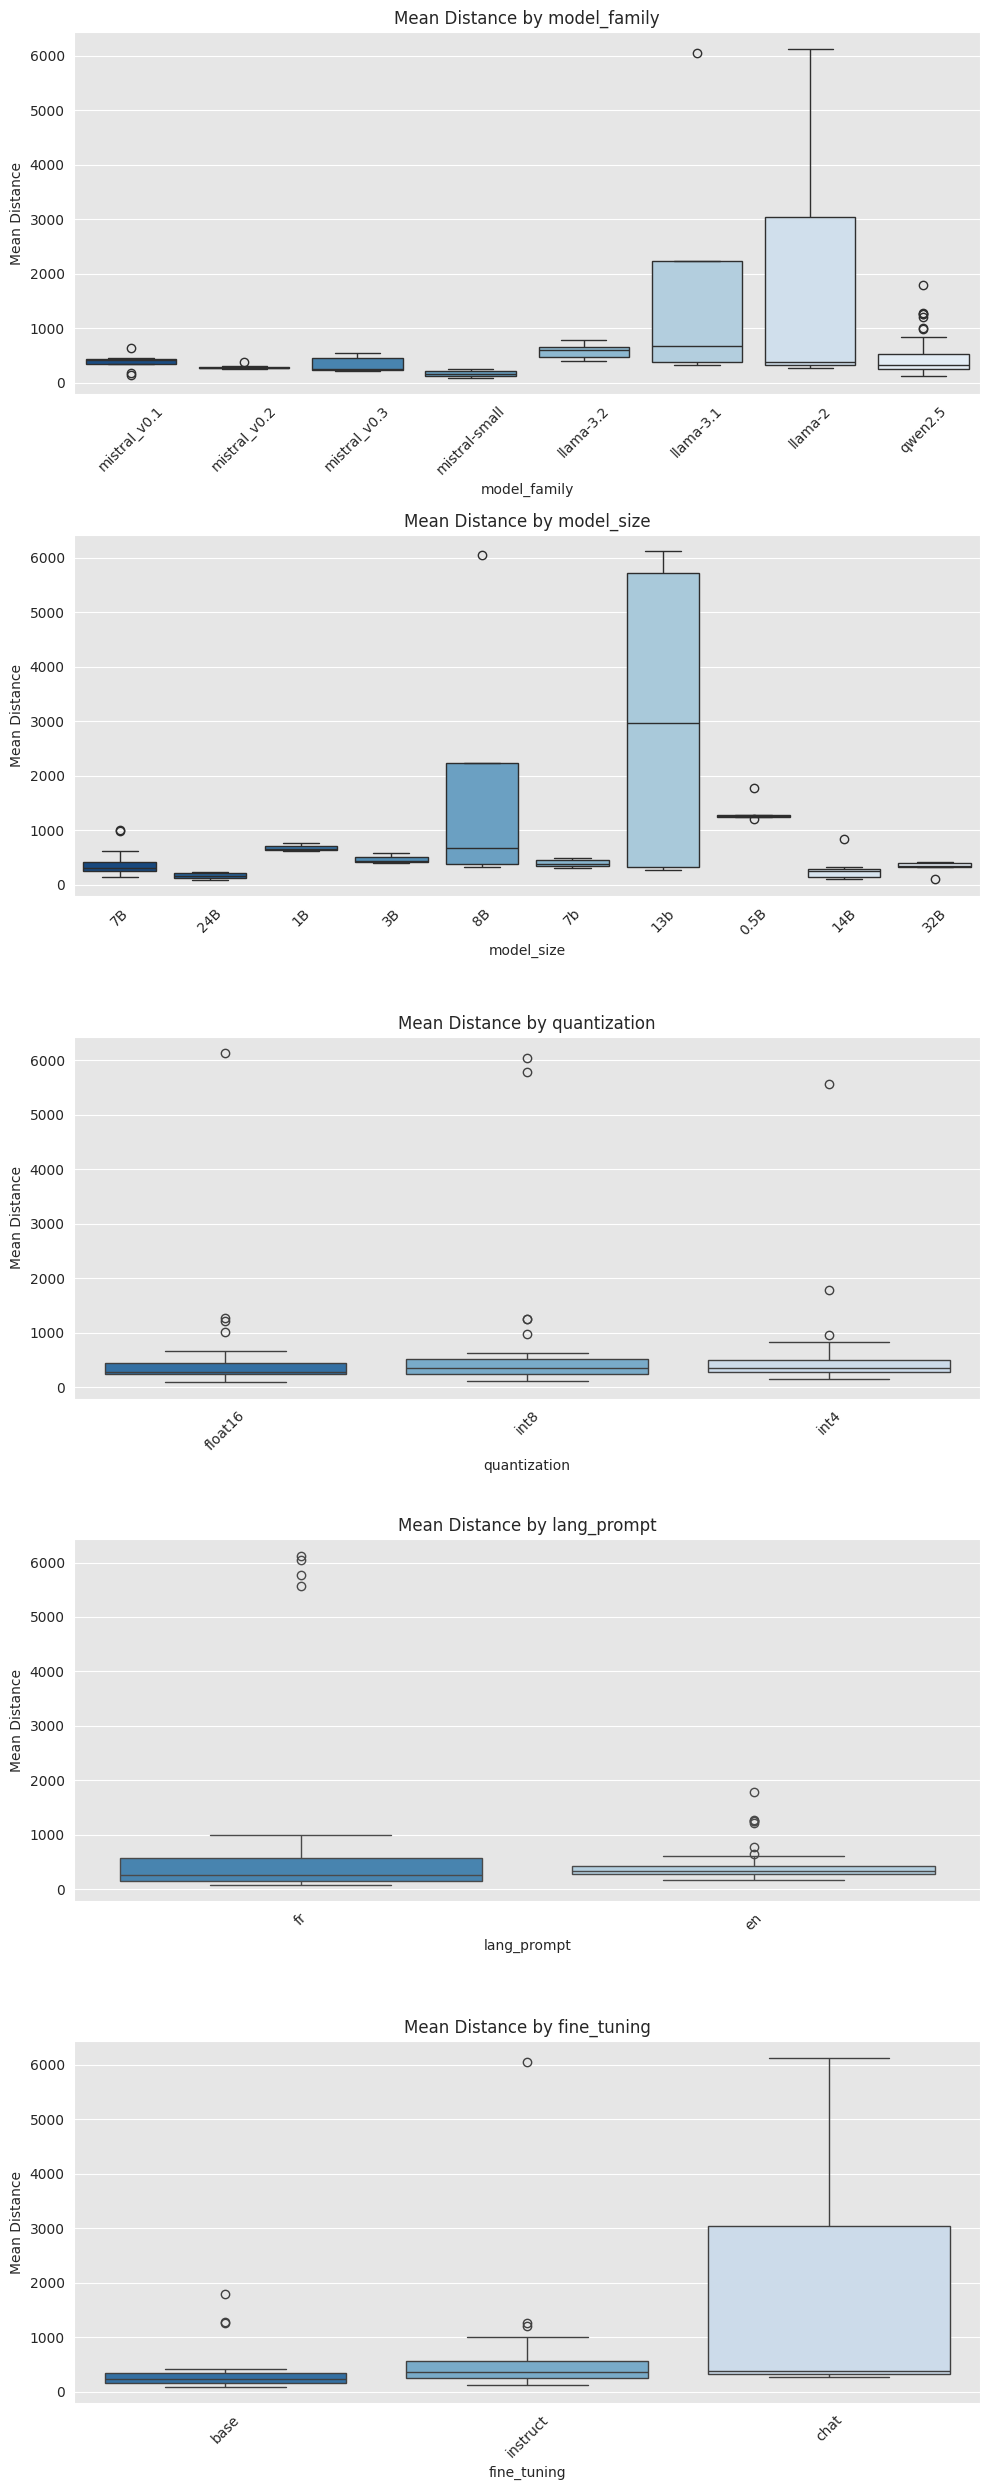

In [85]:
criteria = ["model_family", "model_size", "quantization", "lang_prompt", "fine_tuning"]

# Set up the figure
fig, axes = plt.subplots(nrows=len(criteria), figsize=(10, 5 * len(criteria)))

# Loop through each categorical column and create a bar plot
for i, col in enumerate(criteria):
    ax = axes[i]
    sns.boxplot(data=df, x=col, y="distance_mean", palette="Blues_r", ax=ax)
    ax.set_title(f"Mean Distance by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Mean Distance")
    ax.tick_params(axis="x", rotation=45)  # Rotate x-axis labels if needed

plt.tight_layout()  # Adjust spacing
plt.show()

## Same but without outliers

/tmp/ipykernel_4008488/2976410471.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_without_outliers, x=col, y="distance_mean", palette="Blues_r", ax=ax)
/tmp/ipykernel_4008488/2976410471.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_without_outliers, x=col, y="distance_mean", palette="Blues_r", ax=ax)
/tmp/ipykernel_4008488/2976410471.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_without_outliers, x=col, y="distance_mean", palette="Blues_r", ax=ax)
/tmp/ipykernel_4008488/2976410471.py:8: FutureWarning: 

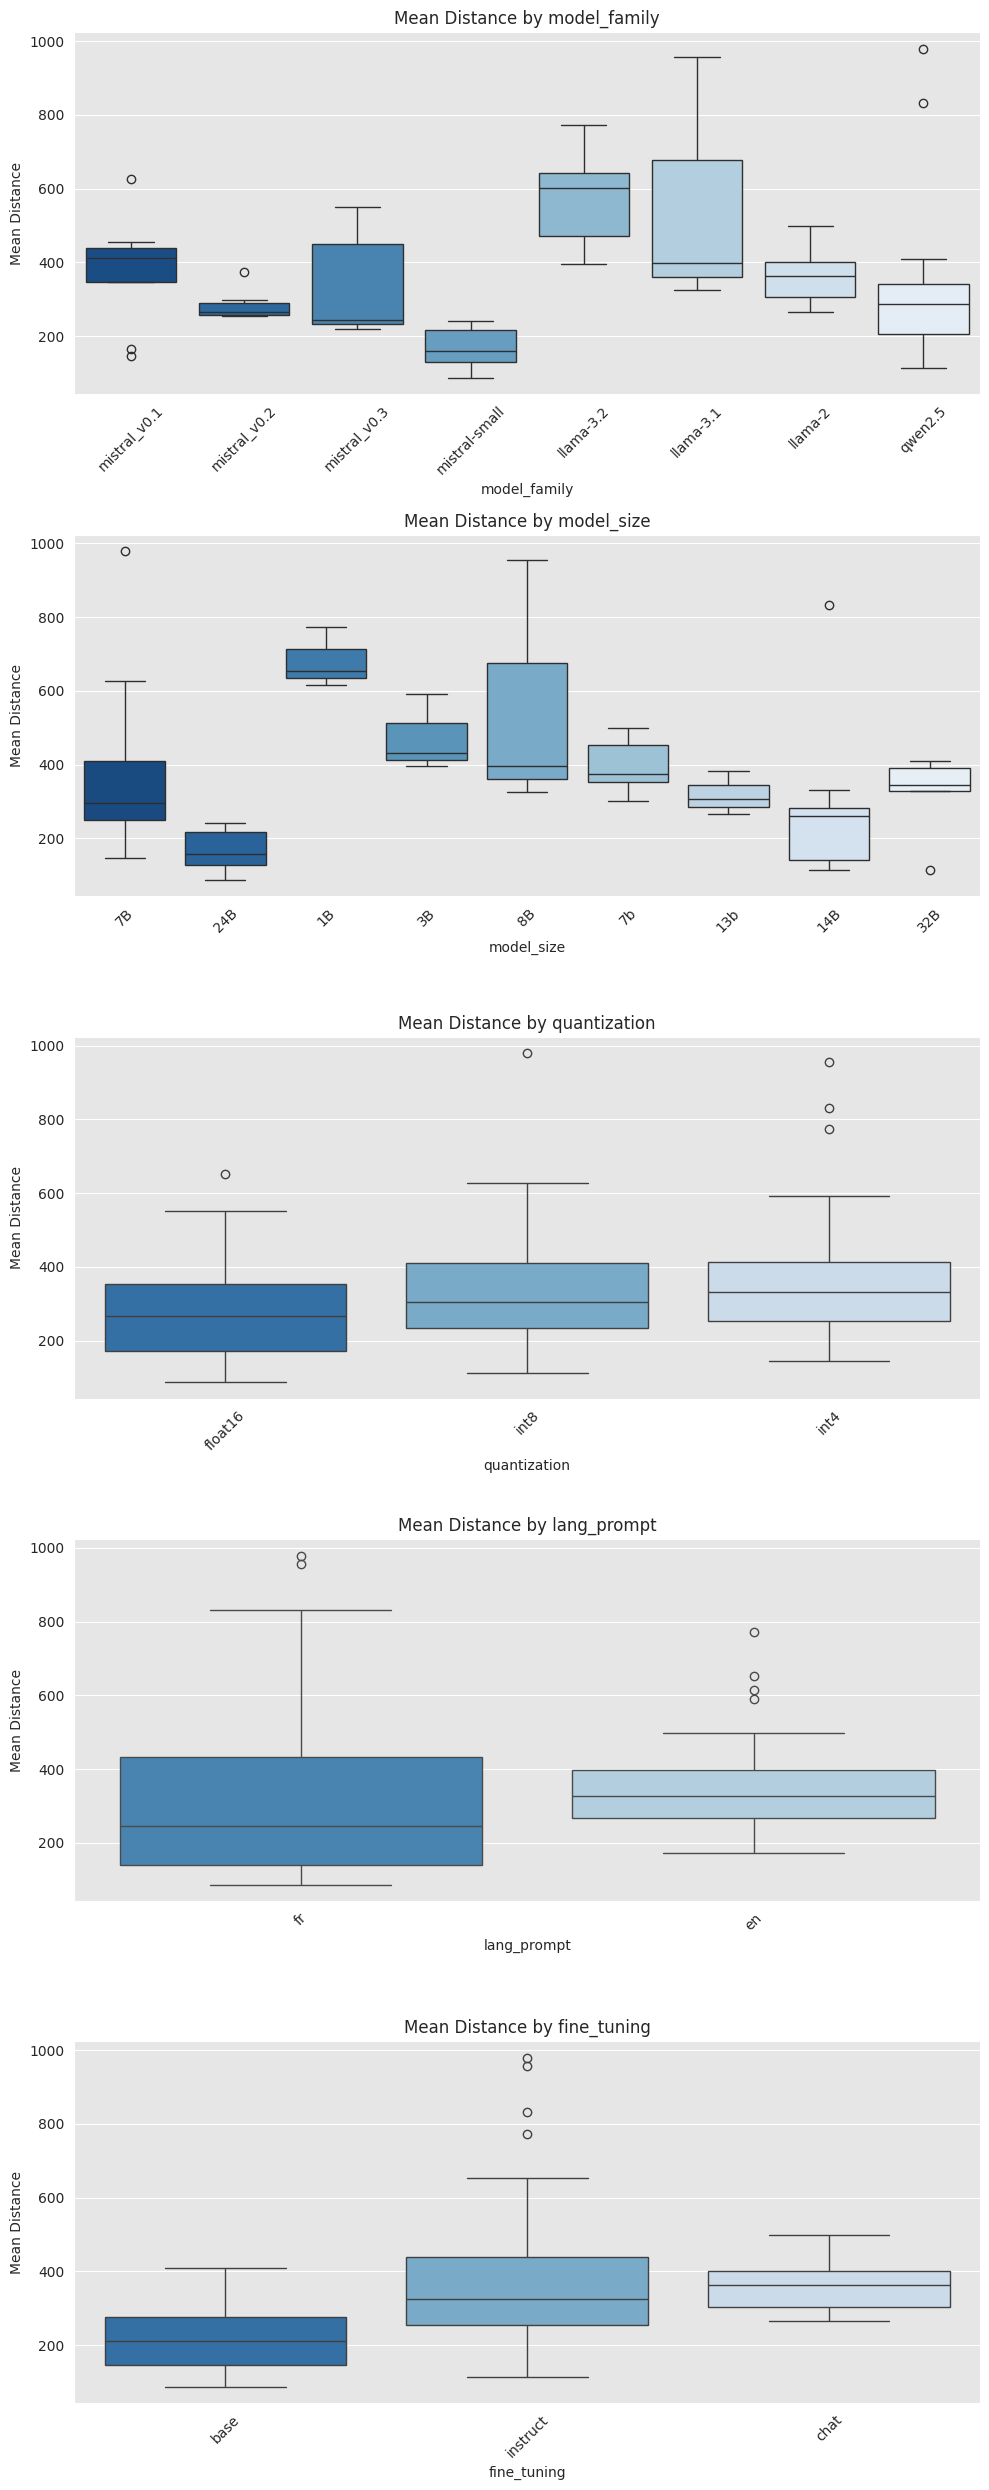

In [86]:
df_without_outliers = df[df["distance_mean"] < 1000]

fig, axes = plt.subplots(nrows=len(criteria), figsize=(10, 5 * len(criteria)))

# Loop through each categorical column and create a bar plot
for i, col in enumerate(criteria):
    ax = axes[i]
    sns.boxplot(data=df_without_outliers, x=col, y="distance_mean", palette="Blues_r", ax=ax)
    ax.set_title(f"Mean Distance by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Mean Distance")
    ax.tick_params(axis="x", rotation=45)  # Rotate x-axis labels if needed

plt.tight_layout()  # Adjust spacing
plt.show()

## Focus on Qwen

/tmp/ipykernel_4008488/3712736874.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_without_outliers, x=col, y="distance_mean", palette="Blues_r", ax=ax)
/tmp/ipykernel_4008488/3712736874.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_without_outliers, x=col, y="distance_mean", palette="Blues_r", ax=ax)
/tmp/ipykernel_4008488/3712736874.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_without_outliers, x=col, y="distance_mean", palette="Blues_r", ax=ax)
/tmp/ipykernel_4008488/3712736874.py:11: FutureWarni

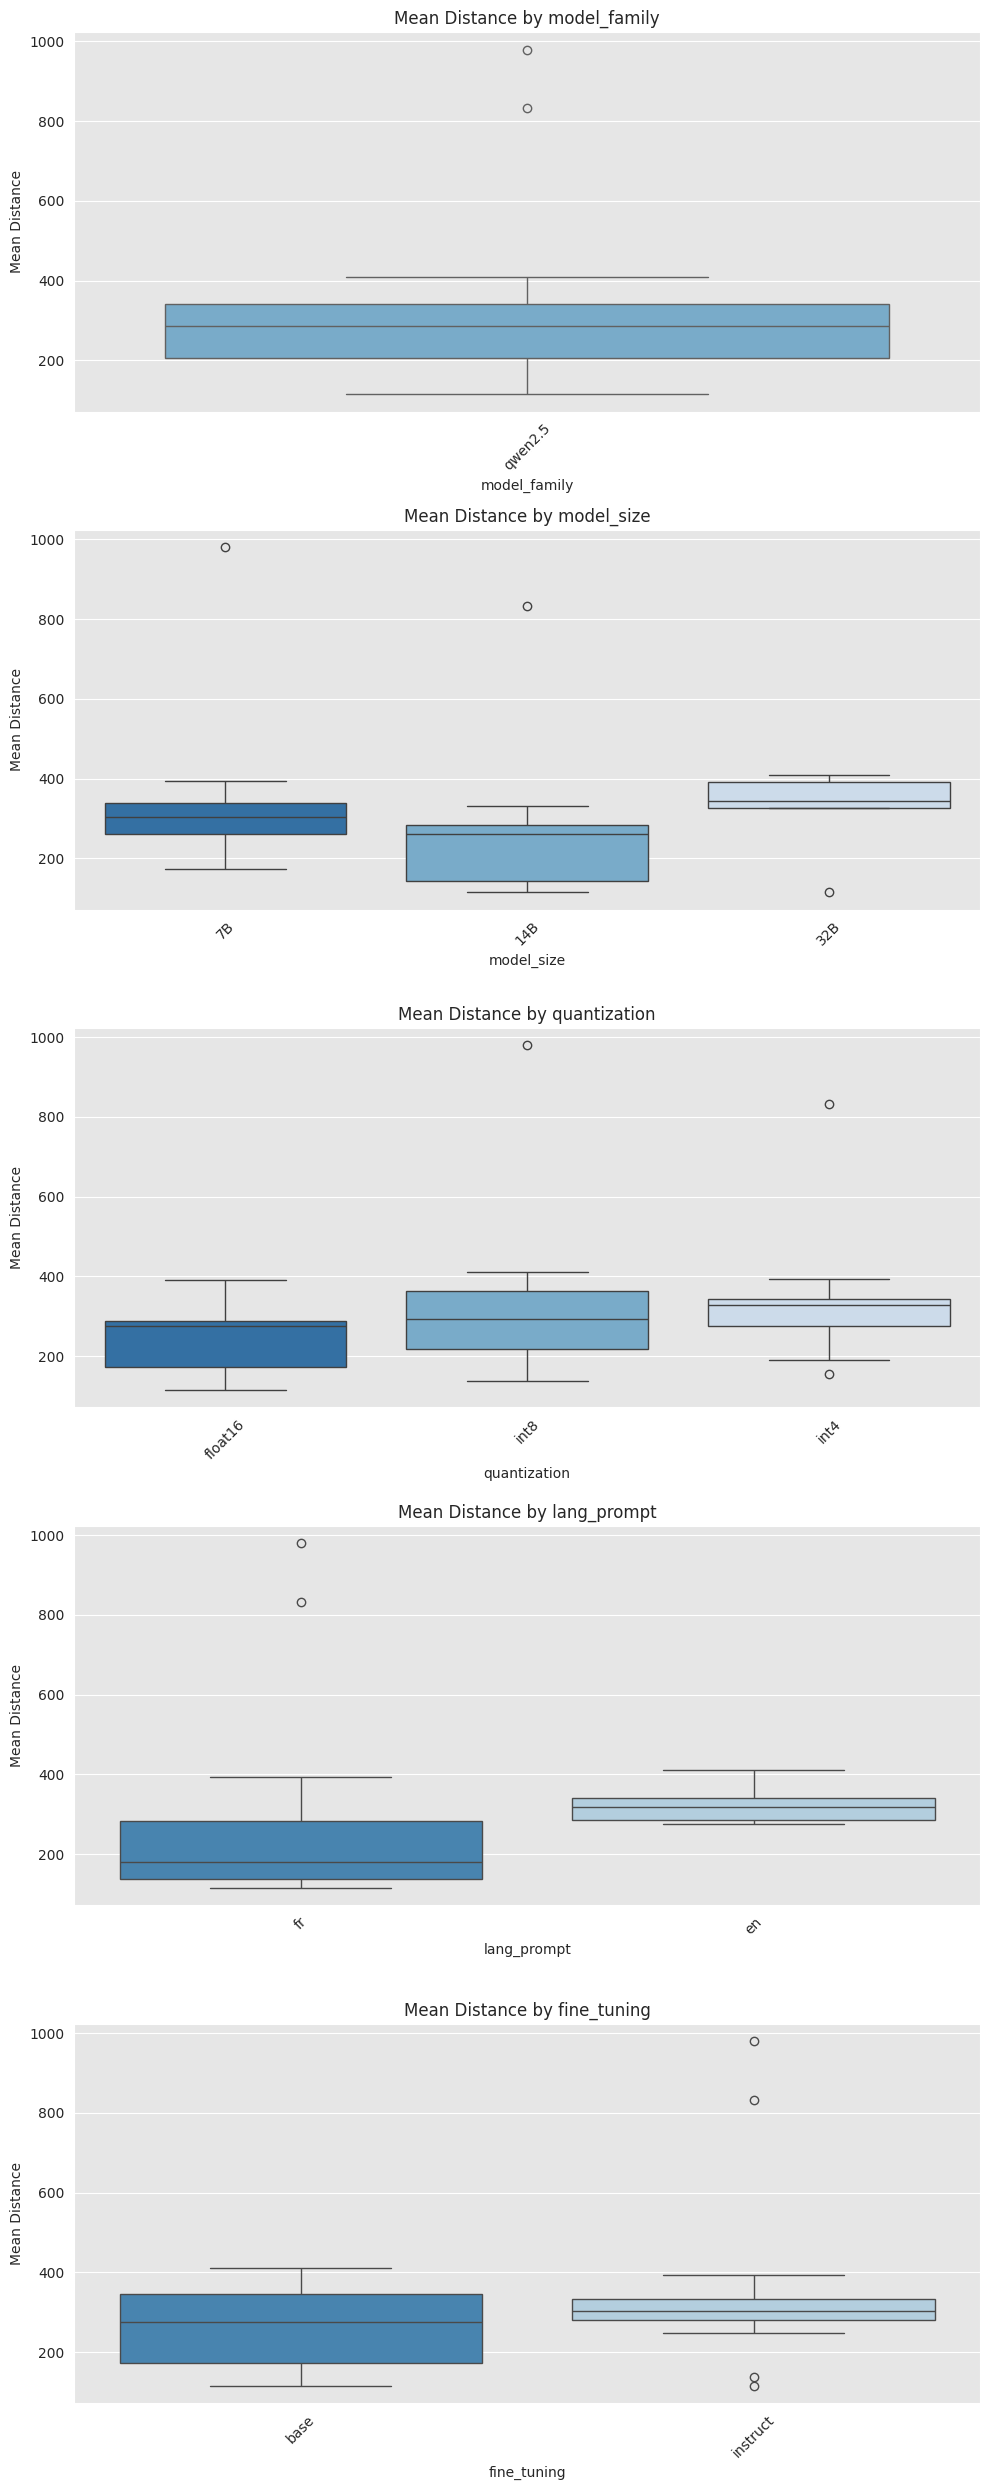

In [87]:
model_family = "qwen2.5"

df_without_outliers = df[df["distance_mean"] < 1000]
df_without_outliers = df_without_outliers[df_without_outliers['model_family'] == model_family ]

fig, axes = plt.subplots(nrows=len(criteria), figsize=(10, 5 * len(criteria)))

# Loop through each categorical column and create a bar plot
for i, col in enumerate(criteria):
    ax = axes[i]
    sns.boxplot(data=df_without_outliers, x=col, y="distance_mean", palette="Blues_r", ax=ax)
    ax.set_title(f"Mean Distance by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Mean Distance")
    ax.tick_params(axis="x", rotation=45)  # Rotate x-axis labels if needed

plt.tight_layout()  # Adjust spacing
plt.show()

## Focus on Llama

In [88]:
model_family = "llama"

df_without_outliers = df[df["distance_mean"] < 1000]
df_without_outliers = df_without_outliers[df_without_outliers['model_family'].str.startswith(model_family)]

df_without_outliers

,distance_mean,nan_counts,model_family,model_size,quantization,lang_prompt,prompt_type,fine_tuning,model_size_num,model_size_str,quantization_num,model_size_fixed
43,652.996909,20,llama-3.2,1B,float16,en,gps,instruct,1.0,1B,16,6
45,614.696545,15,llama-3.2,1B,int8,en,gps,instruct,1.0,1B,8,6
47,772.751842,37,llama-3.2,1B,int4,en,gps,instruct,1.0,1B,4,6
55,432.926028,5,llama-3.2,3B,float16,en,gps,instruct,3.0,3B,16,11
57,394.986821,2,llama-3.2,3B,int8,en,gps,instruct,3.0,3B,8,11
59,591.409713,127,llama-3.2,3B,int4,en,gps,instruct,3.0,3B,4,11
69,397.242878,182,llama-3.1,8B,int8,en,gps,instruct,8.0,8B,8,21
70,955.936555,133,llama-3.1,8B,int4,fr,gps,instruct,8.0,8B,4,21
71,325.026000,0,llama-3.1,8B,int4,en,gps,instruct,8.0,8B,4,21
78,301.909907,101,llama-2,7b,float16,fr,gps,chat,7.0,7B,16,16


/tmp/ipykernel_4008488/1074874473.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_without_outliers, x=col, y="distance_mean", palette="Blues_r", ax=ax)
/tmp/ipykernel_4008488/1074874473.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_without_outliers, x=col, y="distance_mean", palette="Blues_r", ax=ax)
/tmp/ipykernel_4008488/1074874473.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_without_outliers, x=col, y="distance_mean", palette="Blues_r", ax=ax)
/tmp/ipykernel_4008488/1074874473.py:11: FutureWarni

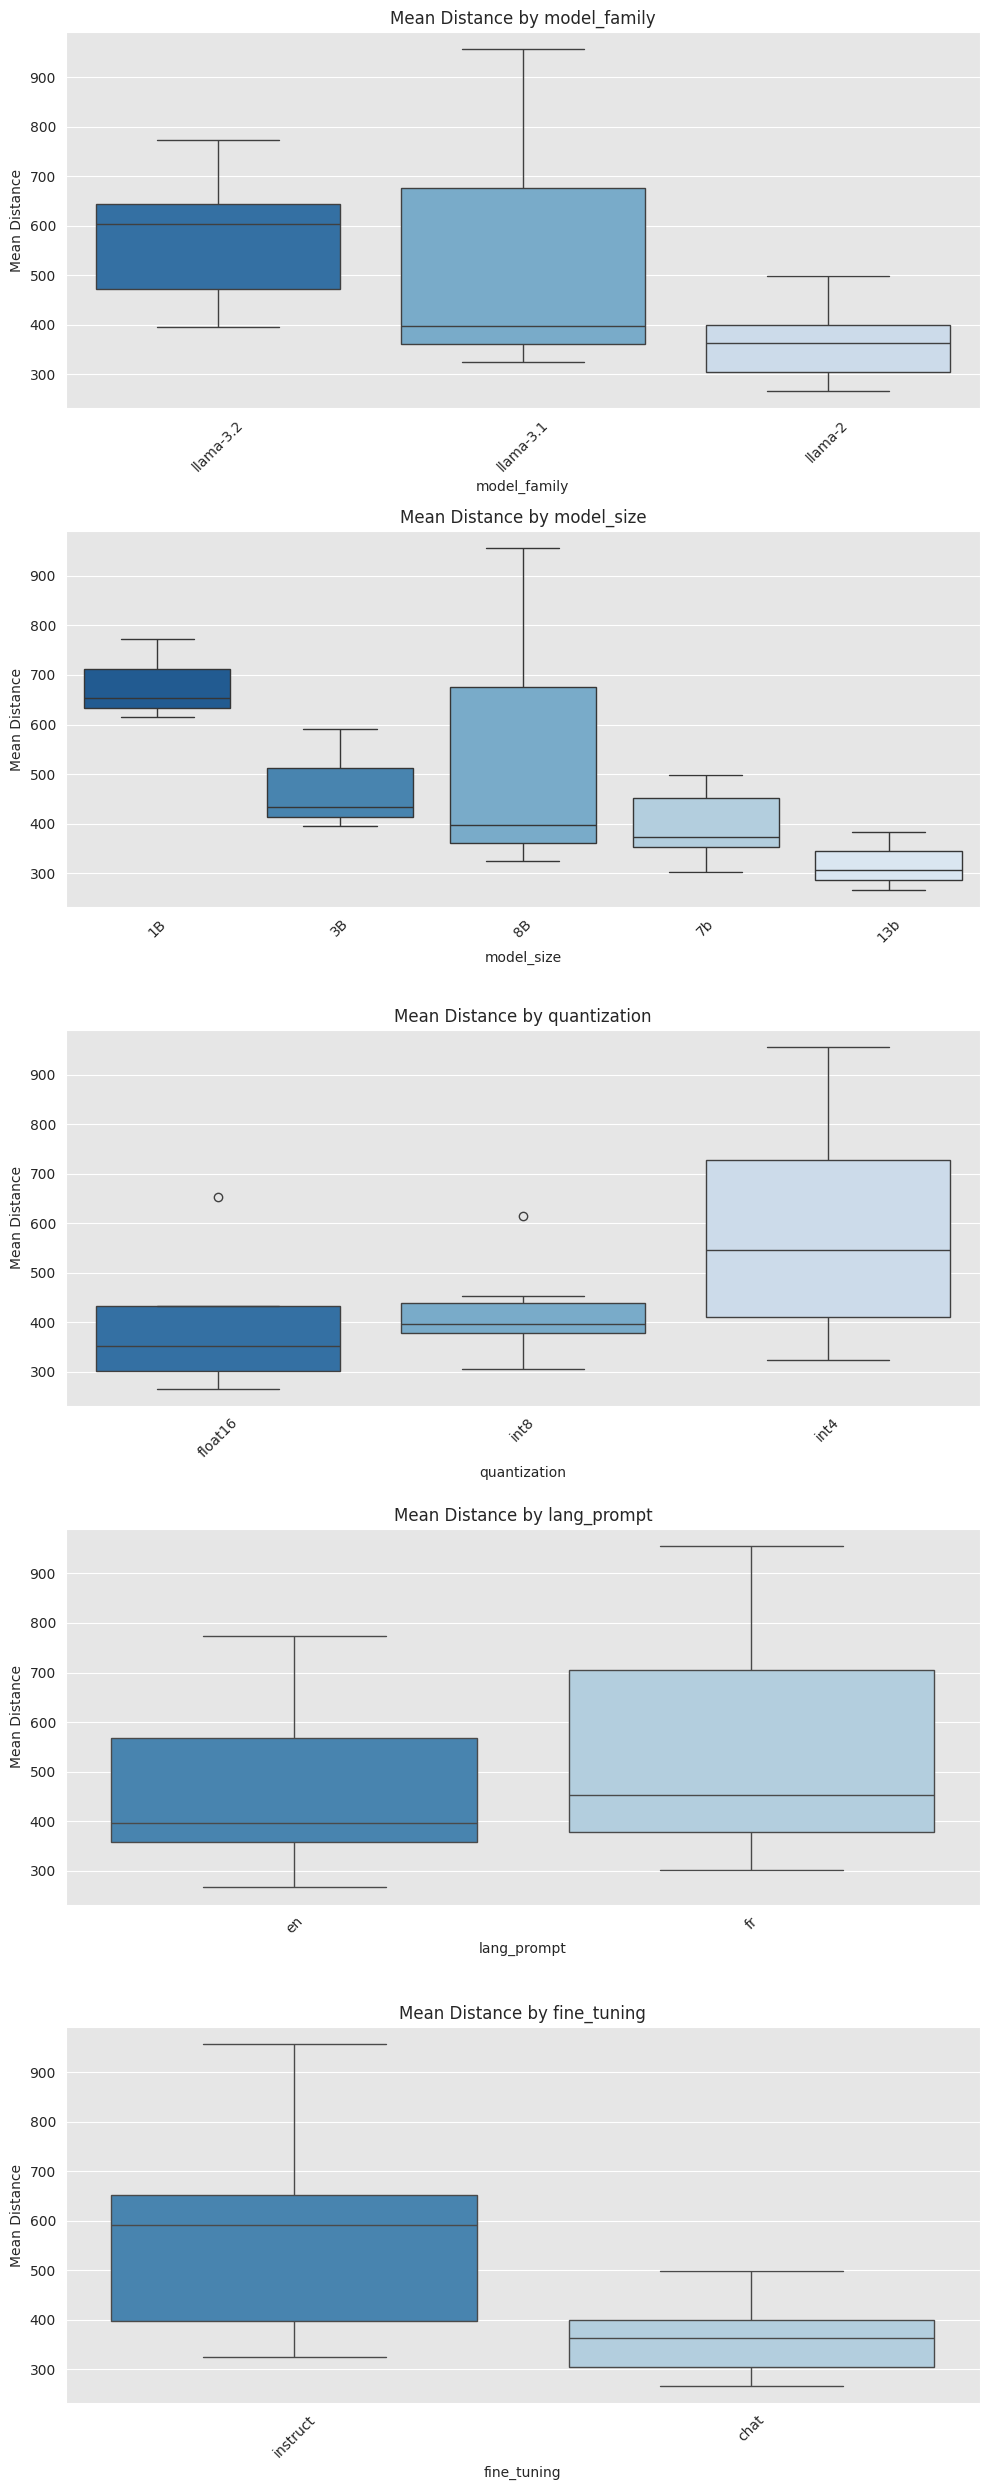

In [89]:
model_family = "llama"

df_without_outliers = df[df["distance_mean"] < 1000]
df_without_outliers = df_without_outliers[df_without_outliers['model_family'].str.startswith(model_family)]

fig, axes = plt.subplots(nrows=len(criteria), figsize=(10, 5 * len(criteria)))

# Loop through each categorical column and create a bar plot
for i, col in enumerate(criteria):
    ax = axes[i]
    sns.boxplot(data=df_without_outliers, x=col, y="distance_mean", palette="Blues_r", ax=ax)
    ax.set_title(f"Mean Distance by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Mean Distance")
    ax.tick_params(axis="x", rotation=45)  # Rotate x-axis labels if needed

plt.tight_layout()  # Adjust spacing
plt.show()